In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
from yaml import Loader, FullLoader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
from matplotlib.ticker import FixedLocator

/home/flipper/anaconda3/envs/birdmigration/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [70]:
def plot_performance(ax, df, label, metric, color, static=False, H=64, ls='standard', z=1, night=False):
    
    if static:
        df = df.groupby('trial').aggregate(np.nanmean).reset_index()
        avg = np.array([np.nanmean(df[metric].values)]*H)
        std = np.array([np.nanstd(df[metric].values)]*H)
        ls = '--' if ls == 'standard' else ls
    elif night:
        grouped = df.groupby('nightID')        
        avg = grouped[metric].aggregate(np.nanmean).values[-H:]
        std = grouped[metric].aggregate(np.nanstd).values[-H:]
        ls = '-' if ls == 'standard' else ls
    else:
        grouped = df.groupby('horizon')        
        avg = grouped[metric].aggregate(np.nanmean).values[-H:]
        std = grouped[metric].aggregate(np.nanstd).values[-H:]
        ls = '-' if ls == 'standard' else ls
    
    line = ax.plot(range(1,H+1), avg, label=label, ls=ls, color=color, linewidth=1.8, zorder=z)
    ax.fill_between(range(1, H+1), avg-std, avg+std, color=color, alpha=0.2, zorder=z)

In [3]:
home = osp.expanduser("~")
base_dir = osp.join(home, 'birdMigration')
result_dir = osp.join(base_dir, 'results')
output_dir = osp.join(base_dir, 'data', 'plots', 'final_fixedT0')
os.makedirs(output_dir, exist_ok=True)

In [102]:
df = pd.read_csv('~/birdMigration/results/radar/FluxRGNN/test_2017/final/trial_1/results_fixedT0.csv')
df_prep = pd.read_csv(osp.join(base_dir, 'data', 'preprocessed',
                    '1H_voronoi_ndummy=15',
                    'radar', 'fall', '2017', 'dynamic_features.csv'))
tidx2night = dict(zip(df_prep.tidx, df_prep.nightID))

In [103]:
df['nightID'] = df.tidx.apply(lambda x: tidx2night[x])
df = df.query('missing == 0')
results = df.groupby(['nightID', 'trial', 'seqID', 'radar']).aggregate(np.mean)
results = results.reset_index()

results[f'squared_error_night{ext}'] = (results[f'residual{ext}'] / bs).pow(2)
#df = results.query(f'missing == 0 & gt{ext} >= {threshold}')

df.groupby('seqID').nightID.value_counts()
#results.missing.value_counts()

seqID  nightID
0      0.0        1601
       73.0        272
       75.0        270
       74.0        263
       76.0        261
                  ... 
59     0.0        1586
       77.0        264
       79.0        264
       78.0        259
       80.0        259
Name: nightID, Length: 303, dtype: int64

In [76]:
C, H = 24, 72
test_year = 2017

# load configs for abm and radar experiments
bscale = {}
abm_cfg = osp.join(result_dir, 'abm', 'GBT', f'test_{test_year}', 
                   'final', 'trial_1', 'config.yaml')
with open(abm_cfg) as f:
    config = load(f, Loader=FullLoader)
    bscale['abm'] = config['datasource']['bird_scale']
    
radar_cfg = osp.join(result_dir, 'radar', 'GBT', f'test_{test_year}', 
                     'final', 'trial_1', 'config.yaml')
with open(radar_cfg) as f:
    config = load(f, Loader=FullLoader)
    bscale['radar'] = config['datasource']['bird_scale']

In [6]:
# define baseline models and their labels
baseline_models = {('HA', 'final'): 'HA',
          ('GAM', 'final'): 'GAM',
          ('GBT', 'final'): 'GBT'}
# define FluxRGNN-type models and their labels
flux_models = {    
          ('FluxRGNN', 'final'): 'FluxRGNN', 
          ('LocalLSTM', 'final'): 'w/o fluxes',       
          ('FluxRGNN', 'final_without_encoder'): 'w/o encoder',
          ('FluxRGNN', 'final_without_boundary'): 'w/o boundary'}
# define colors
baseline_colors = ['#cccccc', '#999999', '#404040']
baseline_ls = ['--', '-.', ':']
flux_colors = ['#ff7f00', '#b30000', '#999966', '#008080']

### ***Predictive performance***

In [82]:
summary_dir = 'performance_evaluation_fixedT0'

metric = 'rmse'

H=72

fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline_rmse = pd.read_csv(osp.join(result_dir, 'abm', 
                summary_dir, 'final', f'{metric}_per_hour.csv'))
baseline_pcc = pd.read_csv(osp.join(result_dir, 'abm', 
                summary_dir, 'final', 'pcc_per_hour.csv'))

baseline_rmse[metric] /= bscale['abm']

rmse_per_hour = pd.read_csv(osp.join(result_dir, 'abm', 
                summary_dir, 'ablations', f'{metric}_per_hour.csv'))
pcc_per_hour = pd.read_csv(osp.join(result_dir, 'abm', 
                summary_dir, 'ablations', 'pcc_per_hour.csv'))

rmse_per_hour[metric] /= bscale['abm']



for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric, static=False, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=False, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    #if m == 'FluxRGNN' and e == 'final':
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric, static=False, H=H, color=flux_colors[i])
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=False, H=H, color=flux_colors[i])


    
ax[0].set_ylabel(metric.capitalize(), fontsize=14)
ax[1].set_ylabel('Pearson r', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.47), framealpha=1)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, f'abm_{metric}_pcc_per_hour.png'), bbox_inches='tight', dpi=200)

In [84]:
summary_dir = 'performance_evaluation_fixedT0'

metric1 = 'rmse'
metric2 = 'mae'

H=3

fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline1 = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'final', f'{metric1}_per_night.csv'))
baseline2 = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'final', f'{metric2}_per_night.csv'))

baseline1[metric1] /= bscale['radar']
baseline2[metric2] /= bscale['radar']

metric1_per_night = pd.read_csv(osp.join(result_dir, 'abm', 
                summary_dir, 'ablations', f'{metric1}_per_night.csv'))
metric2_per_night = pd.read_csv(osp.join(result_dir, 'abm', 
                summary_dir, 'ablations', f'{metric2}_per_night.csv'))

metric1_per_night[metric1] /= bscale['abm']
metric2_per_night[metric2] /= bscale['abm']


for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline1.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric1, static=False, H=H, night=True,
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline2.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric2, static=False, H=H, night=True,
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    #if m == 'FluxRGNN' and e == 'final':
    plot_performance(ax[0], metric1_per_night.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric1, static=False, H=H, color=flux_colors[i], night=True)
    plot_performance(ax[1], metric2_per_night.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric2, static=False, H=H, color=flux_colors[i], night=True)


    
ax[0].set_ylabel(metric1.capitalize(), fontsize=14)
ax[1].set_ylabel(metric2.capitalize(), fontsize=14)
ax[1].set_xlabel('forcasting horizon [night]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.47), framealpha=1)
ax[0].set_title('Simulated data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, f'abm_{metric1}_{metric2}_per_night.png'), bbox_inches='tight', dpi=200)

In [71]:
summary_dir = 'performance_evaluation_fixedT0'

metric = 'rmse'

H=64

fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline_rmse = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'final', f'{metric}_per_hour.csv'))
baseline_pcc = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'final', 'pcc_per_hour.csv'))

baseline_rmse[metric] /= bscale['radar']

rmse_per_hour = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'ablations', f'{metric}_per_hour.csv'))
pcc_per_hour = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'ablations', 'pcc_per_hour.csv'))

rmse_per_hour[metric] /= bscale['radar']



for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric, static=False, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=False, H=H, 
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    #if m == 'FluxRGNN' and e == 'final':
    plot_performance(ax[0], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric, static=False, H=H, color=flux_colors[i])
    plot_performance(ax[1], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, 'pcc', static=False, H=H, color=flux_colors[i])


    
ax[0].set_ylabel(metric.capitalize(), fontsize=14)
ax[1].set_ylabel('Pearson r', fontsize=14)
ax[1].set_xlabel('forcasting horizon [h]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.47), framealpha=1)
ax[0].set_title('Radar data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, f'radar_{metric}_pcc_per_hour.png'), bbox_inches='tight', dpi=200)

In [108]:
summary_dir = 'performance_evaluation_fixedT0'

metric1 = 'rmse'
metric2 = 'mae'

H=3

fig, ax = plt.subplots(nrows=2, figsize=(6.5,7), sharex=True)

baseline1 = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'final', f'{metric1}_per_night.csv'))
baseline2 = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'final', f'{metric2}_per_night.csv'))

baseline1[metric1] /= bscale['radar']
baseline2[metric2] /= bscale['radar']

metric1_per_night = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'ablations', f'{metric1}_per_night.csv'))
metric2_per_night = pd.read_csv(osp.join(result_dir, 'radar', 
                summary_dir, 'ablations', f'{metric2}_per_night.csv'))

metric1_per_night[metric1] /= bscale['radar']
metric2_per_night[metric2] /= bscale['radar']


for i, ((m, e), label) in enumerate(baseline_models.items()):
    plot_performance(ax[0], baseline1.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric1, static=False, H=H, night=True,
                     color=baseline_colors[i], ls=baseline_ls[i])
    plot_performance(ax[1], baseline2.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric2, static=False, H=H, night=True,
                     color=baseline_colors[i], ls=baseline_ls[i])

for i, ((m, e), label) in enumerate(flux_models.items()):
    #if m == 'FluxRGNN' and e == 'final':
    plot_performance(ax[0], metric1_per_night.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric1, static=False, H=H, color=flux_colors[i], night=True)
    plot_performance(ax[1], metric2_per_night.query(f'model == "{m}" & experiment == "{e}"'), 
                     label, metric2, static=False, H=H, color=flux_colors[i], night=True)


    
ax[0].set_ylabel(metric1.capitalize(), fontsize=14)
ax[1].set_ylabel(metric2.capitalize(), fontsize=14)
ax[1].set_xlabel('forcasting horizon [night]', fontsize=14)
ax[1].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.47), framealpha=1)
ax[0].set_title('Radar data', fontsize=14)

for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, f'radar_{metric1}_{metric2}_per_night.png'), bbox_inches='tight', dpi=200)

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

### ***Ablation study***

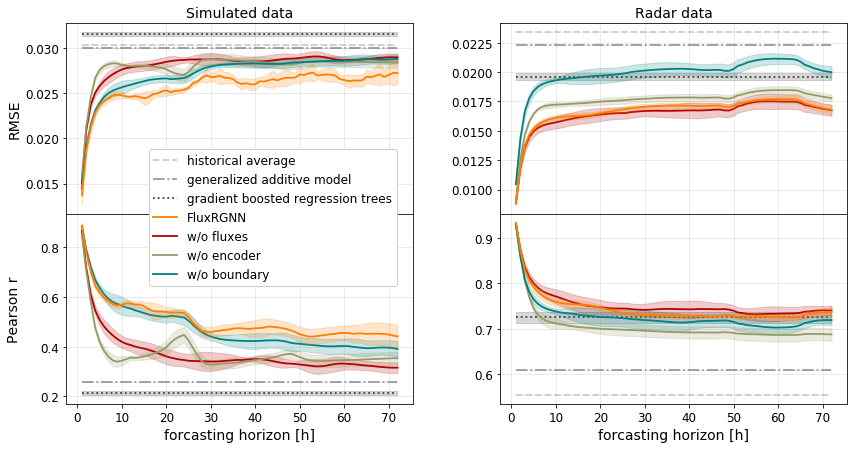

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,7), sharex=True)

metric = 'rmse'

for i, datasource in enumerate(['abm', 'radar']):
    
    # load baseline performance
    baseline_rmse = pd.read_csv(osp.join(result_dir, datasource, 
                    summary_dir, 'final', f'{metric}_per_hour.csv'))
    baseline_pcc = pd.read_csv(osp.join(result_dir, datasource, 
                    summary_dir, 'final', 'pcc_per_hour.csv'))
    baseline_rmse[metric] /= bscale[datasource]
    
    # load FluxRGNN performance
    rmse_per_hour = pd.read_csv(osp.join(result_dir, datasource, 
                    summary_dir, 'ablations', f'{metric}_per_hour.csv'))
    pcc_per_hour = pd.read_csv(osp.join(result_dir, datasource, 
                    summary_dir, 'ablations', 'pcc_per_hour.csv'))
    rmse_per_hour[metric] /= bscale[datasource]


    for j, ((m, e), label) in enumerate(baseline_models.items()):
        plot_performance(ax[0, i], baseline_rmse.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'rmse', static=False, H=H, 
                         color=baseline_colors[j], ls=baseline_ls[j])
        plot_performance(ax[1, i], baseline_pcc.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'pcc', static=False, H=H, 
                         color=baseline_colors[j], ls=baseline_ls[j])

    for j, ((m, e), label) in enumerate(flux_models.items()):
        if m == 'FluxRGNN' and e == 'final':
            z = 2
        else:
            z = 1
        plot_performance(ax[0, i], rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'rmse', static=False, H=H, color=flux_colors[j], z=z)
        plot_performance(ax[1, i], pcc_per_hour.query(f'model == "{m}" & experiment == "{e}"'), 
                         label, 'pcc', static=False, H=H, color=flux_colors[j], z=z)

    ax[1,i].set_xlabel('forcasting horizon [h]', fontsize=14)
    
ax[0,0].set_ylabel(metric.capitalize(), fontsize=14)
ax[1,0].set_ylabel('Pearson r', fontsize=14)
ax[1,0].legend(loc='upper right', fontsize=12, 
            bbox_to_anchor=(0.97,1.37), framealpha=1)
ax[0,0].set_title('Simulated data', fontsize=14)
ax[0,1].set_title('Radar data', fontsize=14)

for axis in ax.flatten():
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.grid(color = 'gray', linestyle = '-', alpha=0.2)

fig.subplots_adjust(wspace=0.25, hspace=0)
fig.align_ylabels(ax)
fig.savefig(osp.join(output_dir, f'{metric}_pcc_per_hour_combined.png'), bbox_inches='tight', dpi=200)